- Simulasi sehat>0: **493 / 500**

- Simulasi sehat>0 & sisa>0: **493 / 500**

- Best sample id: **389**, skor: **110.74**, sehat: **11.00**, sisa: **210500**

,day,morning,morning_price,evening,evening_price
0,1,cireng,10000,nasigoreng,14000
1,2,ayamgeprek,15000,bubur,10000
2,3,bubur,10000,buah,8000
3,4,ayamgeprek,15000,ayamgeprek,15000
4,5,cireng,10000,nasi telur,14500
5,6,buah,8000,nasigoreng,14000
6,7,capcay,15000,seblak,15000
7,8,salad,18000,buah,8000
8,9,bubur,10000,buah,8000
9,10,nasi_uduk,13000,nasigoreng,14000


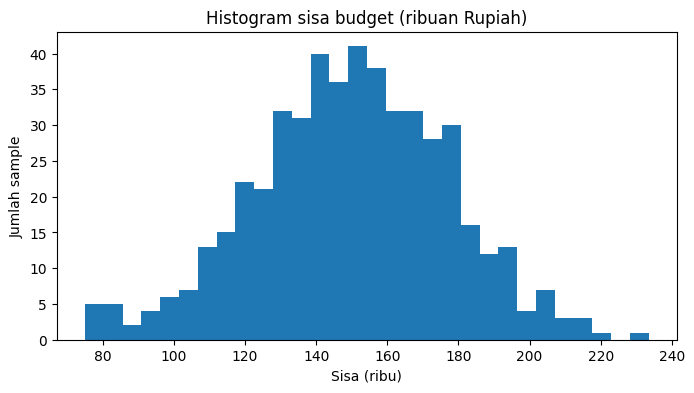

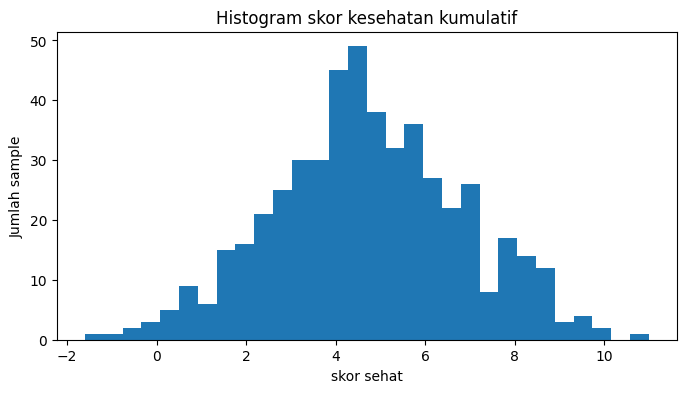

In [14]:
import io, pandas as pd, numpy as np, matplotlib.pyplot as plt
from IPython.display import display, Markdown

makan = pd.read_csv("/content/makanan.csv")

# Fill missing harga menggunakan median
makan['harga'] = pd.to_numeric(makan['harga'], errors='coerce')
median_price = int(makan['harga'].median())
makan['harga'] = makan['harga'].fillna(median_price).astype(int)

# add extra items to increase variety
extra = pd.DataFrame([
    {"makanan":"soto", "kenyang":0.8, "sehat":0.7, "rasa":0.8, "bosan":0.3, "harga":12000},
    {"makanan":"bubur", "kenyang":0.7, "sehat":0.9, "rasa":0.6, "bosan":0.2, "harga":10000},
    {"makanan":"salad", "kenyang":0.6, "sehat":1.0, "rasa":0.6, "bosan":0.1, "harga":18000},
    {"makanan":"buah", "kenyang":0.4, "sehat":1.0, "rasa":0.9, "bosan":0.05, "harga":8000},
    {"makanan":"nasi_uduk", "kenyang":0.9, "sehat":0.6, "rasa":0.85, "bosan":0.4, "harga":13000},
    {"makanan":"sate", "kenyang":0.7, "sehat":0.5, "rasa":0.95, "bosan":0.35, "harga":22000},
])
makan = pd.concat([makan, extra], ignore_index=True).reset_index(drop=True)

# Simulation parameters
NPM = 19102
np.random.seed(NPM)
SAMPLE_NUM = 500
DAYS = 31
MEALS_PER_DAY = 2
budget_start = 1_000_000
wkenyang_base = 0.8
wrasa_base = 0.7
wsehat_base = 0.9
wbosan_base = 0.2

# Storage arrays
skor = np.zeros(SAMPLE_NUM, dtype=float)
sisa = np.zeros(SAMPLE_NUM, dtype=float)
sehat = np.zeros(SAMPLE_NUM, dtype=float)
resp_pilih = np.full((SAMPLE_NUM, DAYS * MEALS_PER_DAY), -1, dtype=int)

SISA_MININUM = 150_000
SISA_MAKSIMUM = 300_000
bin_step = 1000
bin_sisa = np.arange(SISA_MININUM, SISA_MAKSIMUM, bin_step)
resp_sehat = np.zeros((SAMPLE_NUM, len(bin_sisa)), dtype=float)

# Run simulations
for n in range(SAMPLE_NUM):
    budget = budget_start
    skor_kumulatif = 0.0
    skor_sehat = 0.0
    for i in range(DAYS):
        # morning
        pilihan = np.random.randint(0, len(makan))
        w_kenyang = np.random.normal(loc=wkenyang_base, scale=0.2)
        w_rasa = np.random.normal(loc=wrasa_base, scale=0.2)
        w_sehat = np.random.normal(loc=wsehat_base, scale=0.4)
        w_bosan = np.random.normal(loc=wbosan_base, scale=0.2)
        skor_kumulatif += (w_kenyang * makan.loc[pilihan, 'kenyang'] +
                           w_rasa * makan.loc[pilihan, 'rasa'] +
                           w_sehat * makan.loc[pilihan, 'sehat'] -
                           w_bosan * makan.loc[pilihan, 'bosan'])
        skor_sehat += (makan.loc[pilihan, 'sehat'] - 0.5)
        budget -= makan.loc[pilihan, 'harga']
        resp_pilih[n, 2*i] = pilihan

        # evening
        pilihan = np.random.randint(0, len(makan))
        w_kenyang = np.random.normal(loc=wkenyang_base, scale=0.2)
        w_rasa = np.random.normal(loc=wrasa_base, scale=0.2)
        w_sehat = np.random.normal(loc=(wsehat_base + 0.2), scale=0.4)
        w_bosan = np.random.normal(loc=(wbosan_base * 2), scale=0.2)
        skor_kumulatif += (w_kenyang * makan.loc[pilihan, 'kenyang'] +
                           w_rasa * makan.loc[pilihan, 'rasa'] +
                           w_sehat * makan.loc[pilihan, 'sehat'] -
                           w_bosan * makan.loc[pilihan, 'bosan'])
        skor_sehat += (makan.loc[pilihan, 'sehat'] - 0.5)
        budget -= makan.loc[pilihan, 'harga']
        resp_pilih[n, 2*i+1] = pilihan

    sisa[n] = budget
    skor[n] = skor_kumulatif
    sehat[n] = skor_sehat
    idx = int((budget - SISA_MININUM) / bin_step)
    if 0 <= idx < resp_sehat.shape[1]:
        resp_sehat[n, idx] = skor_sehat

# Quick results display
pos_health = (sehat > 0).sum()
pos_health_and_budget = ((sehat > 0) & (sisa > 0)).sum()

display(Markdown(f"- Simulasi sehat>0: **{int(pos_health)} / {SAMPLE_NUM}**"))
display(Markdown(f"- Simulasi sehat>0 & sisa>0: **{int(pos_health_and_budget)} / {SAMPLE_NUM}**"))

# Best sample among sehat>0
mask = sehat > 0
if mask.sum() > 0:
    best_idx = int(np.argmax(skor * mask))
    display(Markdown(f"- Best sample id: **{best_idx}**, skor: **{skor[best_idx]:.2f}**, sehat: **{sehat[best_idx]:.2f}**, sisa: **{sisa[best_idx]:.0f}**"))
    # show first 10 days schedule
    rows = []
    for d in range(10):
        m = int(resp_pilih[best_idx, 2*d])
        e = int(resp_pilih[best_idx, 2*d+1])
        rows.append([d+1, makan.loc[m,'makanan'], int(makan.loc[m,'harga']), makan.loc[e,'makanan'], int(makan.loc[e,'harga'])])
    df_sched = pd.DataFrame(rows, columns=['day','morning','morning_price','evening','evening_price'])
    display(df_sched)
else:
    display(Markdown("No sample has sehat>0"))

# Plot histograms
plt.figure(figsize=(8,4))
plt.hist(sisa/1000, bins=30)
plt.title("Histogram sisa budget (ribuan Rupiah)")
plt.xlabel("Sisa (ribu)")
plt.ylabel("Jumlah sample")
plt.show()

plt.figure(figsize=(8,4))
plt.hist(sehat, bins=30)
plt.title("Histogram skor kesehatan kumulatif")
plt.xlabel("skor sehat")
plt.ylabel("Jumlah sample")
plt.show()


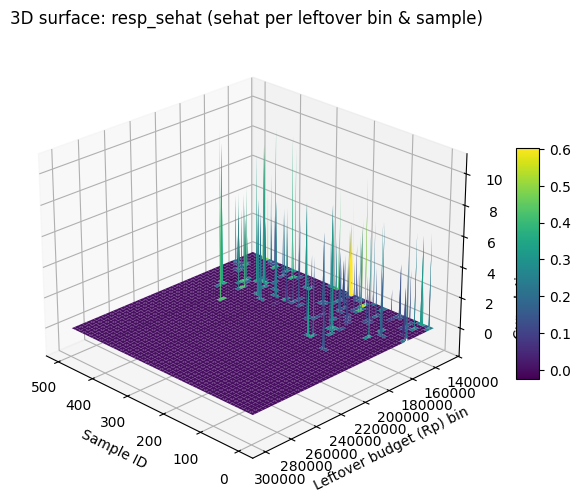

CSV files saved to /content: hasil_simulasi.csv, resp_pilih_indices.csv, resp_pilih_names.csv, best_sample_full_schedule.csv, resp_sehat_matrix.csv


In [15]:
# 3D SURFACE & EXPORT CSVs
import os
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# 3D surface plot of resp_sehat
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(np.arange(SAMPLE_NUM), bin_sisa)
Z = resp_sehat.T
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
ax.set_xlabel('Sample ID')
ax.set_ylabel('Leftover budget (Rp) bin')
ax.set_zlabel('Cumulative sehat score')
ax.set_title('3D surface: resp_sehat (sehat per leftover bin & sample)')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.view_init(elev=25, azim=135)
plt.show()

# Save CSV outputs to working directory
out_dir = '/content'  # Colab working dir
os.makedirs(out_dir, exist_ok=True)

df_results = pd.DataFrame({'sample_id': np.arange(SAMPLE_NUM), 'skor': skor, 'sehat': sehat, 'sisa': sisa})
df_results.to_csv(os.path.join(out_dir, 'hasil_simulasi.csv'), index=False)

col_names_idx = [f'meal_{i+1}_idx' for i in range(DAYS*MEALS_PER_DAY)]
df_resp_idx = pd.DataFrame(resp_pilih, columns=col_names_idx)
df_resp_idx.to_csv(os.path.join(out_dir, 'resp_pilih_indices.csv'), index=False)

names = makan['makanan'].tolist()
df_resp_names = df_resp_idx.replace({i: names[i] for i in range(len(names))})
df_resp_names.to_csv(os.path.join(out_dir, 'resp_pilih_names.csv'), index=False)

# Full schedule for best sample
mask = sehat > 0
best_idx = int(np.argmax(skor * mask)) if mask.sum()>0 else None
if best_idx is not None:
    rows = []
    for d in range(DAYS):
        m_idx = int(resp_pilih[best_idx, 2*d])
        e_idx = int(resp_pilih[best_idx, 2*d+1])
        rows.append({
            'day': d+1,
            'morning_idx': m_idx, 'morning_name': names[m_idx], 'morning_price': int(makan.loc[m_idx,'harga']),
            'evening_idx': e_idx, 'evening_name': names[e_idx], 'evening_price': int(makan.loc[e_idx,'harga']),
        })
    df_best_schedule = pd.DataFrame(rows)
    df_best_schedule.to_csv(os.path.join(out_dir, 'best_sample_full_schedule.csv'), index=False)

df_resp_sehat = pd.DataFrame(resp_sehat.T, index=bin_sisa, columns=[f'sample_{i}' for i in range(SAMPLE_NUM)])
df_resp_sehat.to_csv(os.path.join(out_dir, 'resp_sehat_matrix.csv'))

print("CSV files saved to /content: hasil_simulasi.csv, resp_pilih_indices.csv, resp_pilih_names.csv, best_sample_full_schedule.csv, resp_sehat_matrix.csv")

In [13]:
# DOWNLOAD helper (Colab): ini dijalankan untuk mengunduh file ke komputer lokal
from google.colab import files
files.download('hasil_simulasi.csv')
files.download('resp_pilih_names.csv')
files.download('best_sample_full_schedule.csv')
files.download('resp_sehat_matrix.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>